# Dominos - Sales forecasting and Purchse Order System

## 1. Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

# For SARIMA Model
import statsmodels.api as sm
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

import warnings

# Suppressing the  warnings
warnings.filterwarnings("ignore")

c:\Users\DELL\anaconda3\envs\py8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Importing the Data

In [2]:
Sales_df = pd.read_excel("data/Pizza_Sale.xlsx")
Ingredients_df = pd.read_excel("data/Pizza_ingredients.xlsx")

## 3. Understanding the Data:
* On average, a Domino's store in US sells about 400 pizzas per day. Domino's US sells over 4 million pizzas per month.

### Dataset Overview:
* Pizza_Sale.csv with 48,620 rows and 12 columns.
* Pizza_Ingredients.csv with 518 rows and 4 columns.

### a) Sales Data

In [3]:
Sales_df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [4]:
Sales_df.info()
print('\nShape of the sales data:', Sales_df.shape)
print('\nstatistics of sales data:\n', Sales_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB

Shape of the sales data: (48620, 12)

statistics of sales data:
            pizza_id      order_id      quantity    unit_price   total_price
count  48620.00

### b) Ingredients Data

In [5]:
Ingredients_df.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [6]:
Ingredients_df.info()
print('\nShape of the ingredients data:', Ingredients_df.shape)
print('\nstatistics of ingredients data:\n', Ingredients_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  514 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB

Shape of the ingredients data: (518, 4)

statistics of ingredients data:
        Items_Qty_In_Grams
count          514.000000
mean            30.564202
std             30.351623
min              5.000000
25%             10.000000
50%             20.000000
75%             40.000000
max            200.000000


## 4. Handling Missing Values

### a) Sales Data

In [7]:
Sales_df.isna().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [8]:
# Filling Total Price Based on Quantity

Sales_df['total_price'].fillna(Sales_df['unit_price'] * Sales_df['quantity'], inplace=True)

In [9]:
# Filling Missing Pizza Categories Based on Pizza Name ID

Sales_df['pizza_category'].value_counts()

pizza_category
Classic    14572
Supreme    11771
Veggie     11442
Chicken    10812
Name: count, dtype: int64

In [10]:
Sales_df[Sales_df['pizza_category'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
426,427,181,mexicana_l,1,2015-03-01 00:00:00,18:49:32,20.25,20.25,L,NaN,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
427,428,182,brie_carre_s,1,2015-03-01 00:00:00,18:50:10,23.65,23.65,S,NaN,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza
428,429,182,peppr_salami_l,1,2015-03-01 00:00:00,18:50:10,20.75,20.75,L,NaN,"Genoa Salami, Capocollo, Pepperoni, Tomatoes, ...",The Pepper Salami Pizza
429,430,183,napolitana_m,1,2015-03-01 00:00:00,18:54:55,16.00,16.00,M,NaN,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
430,431,183,spin_pesto_l,1,2015-03-01 00:00:00,18:54:55,20.75,20.75,L,NaN,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza


In [11]:
Sales_df['pizza_name_id'].value_counts()

pizza_name_id
big_meat_s        1811
thai_ckn_l        1363
five_cheese_l     1358
four_cheese_l     1272
classic_dlx_m     1159
                  ... 
mexicana_s         160
calabrese_s         99
ckn_alfredo_s       96
green_garden_l      94
the_greek_xxl       28
Name: count, Length: 91, dtype: int64

In [12]:
category_mapping = Sales_df[['pizza_name_id', 'pizza_category']].dropna().drop_duplicates()
category_mapping = category_mapping.set_index('pizza_name_id')['pizza_category'].to_dict()

Sales_df['pizza_category'] = Sales_df['pizza_category'].fillna(Sales_df['pizza_name_id'].map(category_mapping))

In [13]:
# Filling Missing Pizza Ingredients Based on Pizza Name

Sales_df[Sales_df['pizza_ingredients'].isna()].head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
580,581,254,five_cheese_l,1,2015-04-01 00:00:00,22:22:13,18.5,18.5,L,Veggie,NaN,The Five Cheese Pizza
581,582,255,five_cheese_l,1,2015-05-01 00:00:00,11:23:35,18.5,18.5,L,Veggie,NaN,The Five Cheese Pizza
582,583,255,green_garden_m,1,2015-05-01 00:00:00,11:23:35,16.0,16.0,M,Veggie,NaN,The Green Garden Pizza
583,584,255,hawaiian_l,1,2015-05-01 00:00:00,11:23:35,16.5,16.5,L,Classic,NaN,The Hawaiian Pizza
584,585,255,spinach_fet_m,1,2015-05-01 00:00:00,11:23:35,16.0,16.0,M,Veggie,NaN,The Spinach and Feta Pizza


In [14]:
# Mapping Pizza Name to Fill Pizza Ingredients

ingredients_mapping = Sales_df[['pizza_name', 'pizza_ingredients']].dropna().drop_duplicates()
ingredients_mapping = ingredients_mapping.set_index('pizza_name')['pizza_ingredients'].to_dict()

Sales_df['pizza_ingredients'] = Sales_df['pizza_ingredients'].fillna(Sales_df['pizza_name'].map(ingredients_mapping))

In [15]:
## Filling Missing Pizza Name Based on Pizza Ingredients:
### Mapping Pizza Ingredients to Fill Pizza Name

Sales_df[Sales_df['pizza_name'].isna()]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
688,689,303,pepperoni_s,1,2015-05-01 00:00:00,20:02:51,9.75,9.75,S,Classic,"Mozzarella Cheese, Pepperoni",NaN
689,690,304,hawaiian_s,1,2015-05-01 00:00:00,20:07:58,10.50,10.50,S,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",NaN
690,691,304,mexicana_l,1,2015-05-01 00:00:00,20:07:58,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",NaN
691,692,305,pepperoni_l,1,2015-05-01 00:00:00,20:35:40,15.25,15.25,L,Classic,"Mozzarella Cheese, Pepperoni",NaN
692,693,305,sicilian_s,1,2015-05-01 00:00:00,20:35:40,12.25,12.25,S,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives...",NaN
693,694,305,spicy_ital_m,1,2015-05-01 00:00:00,20:35:40,16.50,16.50,M,Supreme,"Capocollo, Tomatoes, Goat Cheese, Artichokes, ...",NaN
694,695,306,big_meat_s,1,2015-05-01 00:00:00,20:37:40,12.00,12.00,S,Classic,"Bacon, Pepperoni, Italian Sausage, Chorizo Sau...",NaN


In [16]:
len(Sales_df['pizza_ingredients'].value_counts())

32

In [17]:
ingredients_name_mapping = Sales_df[['pizza_ingredients', 'pizza_name']].dropna().drop_duplicates()
ingredients_name_mapping = ingredients_name_mapping.set_index('pizza_ingredients')['pizza_name'].to_dict()

Sales_df['pizza_name'] = Sales_df['pizza_name'].fillna(Sales_df['pizza_ingredients'].map(ingredients_name_mapping))

In [18]:
# Filling Missing Pizza Name ID Based on Pizza Name

name_id_mapping = Sales_df[['pizza_name', 'pizza_name_id']].dropna().drop_duplicates()
name_id_mapping = name_id_mapping.set_index('pizza_name')['pizza_name_id'].to_dict()

# Mapping Pizza Name to Fill Pizza Name ID

Sales_df['pizza_name_id'] = Sales_df['pizza_name_id'].fillna(Sales_df['pizza_name'].map(name_id_mapping))

In [19]:
# Verifing the Changes

Sales_df.isna().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

### b) Ingredients Data

In [20]:
# Handling Missing Values in Ingredients Data

Ingredients_df.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64

In [21]:
Ingredients_df[Ingredients_df['Items_Qty_In_Grams'].isna()]

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN


In [22]:
Ingredients_df[Ingredients_df['pizza_name']=='The Brie Carre Pizza']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
22,brie_carre_s,The Brie Carre Pizza,Brie Carre Cheese,30.0
23,brie_carre_s,The Brie Carre Pizza,Prosciutto,30.0
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
25,brie_carre_s,The Brie Carre Pizza,Pears,10.0
26,brie_carre_s,The Brie Carre Pizza,Thyme,5.0
27,brie_carre_s,The Brie Carre Pizza,Garlic,5.0


In [23]:
Ingredients_df[Ingredients_df['pizza_ingredients']=='Sliced Ham']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN


In [24]:
Ingredients_df[Ingredients_df['pizza_name_id']=='hawaiian_l']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
150,hawaiian_l,The Hawaiian Pizza,Pineapple,45.0
151,hawaiian_l,The Hawaiian Pizza,Mozzarella Cheese,30.0


In [25]:
# Calculateing the Mean for each Pizza Name ID

mean_qty = Ingredients_df.groupby('pizza_name_id')['Items_Qty_In_Grams'].mean()

In [26]:
# Filling missing Items Quantity values using the Mean value

Ingredients_df['Items_Qty_In_Grams'] = Ingredients_df['Items_Qty_In_Grams'].fillna(Ingredients_df['pizza_name_id'].map(mean_qty))

In [27]:
# Checking for remaining missing values in Items_Qty_In_Grams

remaining_missing_qty = Ingredients_df['Items_Qty_In_Grams'].isna().sum()
print(f"Remaining missing Items_Qty_In_Grams: {remaining_missing_qty}")

Remaining missing Items_Qty_In_Grams: 0


In [28]:
Ingredients_df.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64

## 5. Merging Sales and Ingredients DataFrames:

In [29]:
merged_df = pd.merge(Sales_df, Ingredients_df, on='pizza_name_id', how='left')
merged_df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients_x,pizza_name_x,pizza_name_y,pizza_ingredients_y,Items_Qty_In_Grams
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Sliced Ham,25.0
1,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Pineapple,30.0
2,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Mozzarella Cheese,20.0
3,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Pepperoni,40.0
4,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Mushrooms,40.0


In [30]:
merged_df.shape

(267576, 15)

In [31]:
merged_df.isnull().sum()

pizza_id               0
order_id               0
pizza_name_id          0
quantity               0
order_date             0
order_time             0
unit_price             0
total_price            0
pizza_size             0
pizza_category         0
pizza_ingredients_x    0
pizza_name_x           0
pizza_name_y           0
pizza_ingredients_y    0
Items_Qty_In_Grams     0
dtype: int64

In [32]:
merged_df[['pizza_ingredients_x','pizza_ingredients_y']]

,pizza_ingredients_x,pizza_ingredients_y
0,"Sliced Ham, Pineapple, Mozzarella Cheese",Sliced Ham
1,"Sliced Ham, Pineapple, Mozzarella Cheese",Pineapple
2,"Sliced Ham, Pineapple, Mozzarella Cheese",Mozzarella Cheese
3,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Pepperoni
4,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Mushrooms
...,...,...
267571,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Peppers
267572,"Barbecued Chicken, Red Peppers, Green Peppers,...",Green Peppers
267573,"Barbecued Chicken, Red Peppers, Green Peppers,...",Tomatoes
267574,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Onions


In [33]:
merged_df[['pizza_name_x','pizza_name_y']]

,pizza_name_x,pizza_name_y
0,The Hawaiian Pizza,The Hawaiian Pizza
1,The Hawaiian Pizza,The Hawaiian Pizza
2,The Hawaiian Pizza,The Hawaiian Pizza
3,The Classic Deluxe Pizza,The Classic Deluxe Pizza
4,The Classic Deluxe Pizza,The Classic Deluxe Pizza
...,...,...
267571,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267572,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267573,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267574,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza


In [34]:
merged_df.drop(columns=['pizza_name_y', 'pizza_ingredients_y'], inplace=True)
merged_df.rename(columns={
    'pizza_name_x': 'pizza_name',
    'pizza_ingredients_x': 'pizza_ingredients'
}, inplace=True)

In [35]:
merged_df.columns

Index(['pizza_id', 'order_id', 'pizza_name_id', 'quantity', 'order_date',
       'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name',
       'Items_Qty_In_Grams'],
      dtype='object')

In [36]:
merged_df.isna().sum()

pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients     0
pizza_name            0
Items_Qty_In_Grams    0
dtype: int64

In [37]:
merged_df.duplicated().sum()

80204

In [38]:
# Droping duplicate rows from the dataset
merged_df = merged_df.drop_duplicates()

print(f"Number of rows after removing duplicates: {merged_df.shape[0]}")

Number of rows after removing duplicates: 187372


In [39]:
# merged_df1 = merged_df.copy()

In [40]:
# Summary statistics
merged_df.describe()

,pizza_id,order_id,quantity,unit_price,total_price,Items_Qty_In_Grams
count,187372.000000,187372.000000,187372.000000,187372.000000,187372.000000,187372.000000
mean,24312.676030,10702.312405,1.019250,16.914338,17.244843,37.645900
std,14039.560378,6181.841091,0.141575,3.571451,4.419979,35.729459
min,1.000000,1.000000,1.000000,9.750000,9.750000,5.000000
25%,12166.750000,5344.000000,1.000000,12.750000,12.750000,15.000000
50%,24266.000000,10661.000000,1.000000,16.750000,16.750000,20.000000
75%,36494.250000,16112.250000,1.000000,20.500000,20.750000,45.000000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000,200.000000


In [41]:
# Checking the data types and column names
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 187372 entries, 0 to 267573
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pizza_id            187372 non-null  int64  
 1   order_id            187372 non-null  int64  
 2   pizza_name_id       187372 non-null  object 
 3   quantity            187372 non-null  int64  
 4   order_date          187372 non-null  object 
 5   order_time          187372 non-null  object 
 6   unit_price          187372 non-null  float64
 7   total_price         187372 non-null  float64
 8   pizza_size          187372 non-null  object 
 9   pizza_category      187372 non-null  object 
 10  pizza_ingredients   187372 non-null  object 
 11  pizza_name          187372 non-null  object 
 12  Items_Qty_In_Grams  187372 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 20.0+ MB


In [42]:
# # save merged data as csv file
# merged_df.to_csv("merged_df.csv", index=False)

## 6. Feature Exploration and Engineering
### Converting Order Dates to DateTime

In [43]:
def extract_date(date):
    formats = ['%d-%m-%Y', '%d/%m/%Y', '%m/%d/%Y']
    for fmt in formats:
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT

# Applying the function to the 'order_date' column
merged_df['order_date'] = merged_df['order_date'].apply(extract_date)

In [44]:
# Extracting the day of the week
merged_df['day_of_week'] = merged_df['order_date'].dt.dayofweek
# Extracting the month
merged_df['month'] = merged_df['order_date'].dt.month
# Createing a new column for the week number
merged_df['week'] = merged_df['order_date'].dt.isocalendar().week
# Extracting the year
merged_df['year'] = merged_df['order_date'].dt.year

### Adding Holiday Indicator to the Data

In [45]:
!pip install holidays

In [46]:
import holidays

# using US holidays
us_holidays = holidays.US()

# Creating a 'holiday' column that indicates if the order_date was a holiday
merged_df['holiday'] = merged_df['order_date'].apply(lambda x: 1 if x in us_holidays else 0)

# Checking if the holiday flag works
merged_df[['order_date', 'holiday']].head()

,order_date,holiday
0,2015-01-01,1
1,2015-01-01,1
2,2015-01-01,1
3,2015-01-01,1
6,2015-01-01,1


In [47]:
merged_df[['order_date', 'holiday']].tail()

,order_date,holiday
267565,2015-12-31,0
267567,2015-12-31,0
267570,2015-12-31,0
267571,2015-12-31,0
267573,2015-12-31,0


### Adding Weekend Promotion Flag (assuming promotions happen on weekends)

In [48]:
# Creating a 'promotional_period' flag for weekends 
merged_df['promotion'] = merged_df['order_date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

# Checking if the promotion flag works
merged_df[['order_date', 'promotion']].head()

,order_date,promotion
0,2015-01-01,0
1,2015-01-01,0
2,2015-01-01,0
3,2015-01-01,0
6,2015-01-01,0


In [49]:
merged_df[merged_df['promotion'] == 1][['order_date', 'promotion']].head()

,order_date,promotion
910,2015-02-01,1
911,2015-02-01,1
914,2015-02-01,1
917,2015-02-01,1
918,2015-02-01,1


In [50]:
merged_df.isnull().sum()

pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients     0
pizza_name            0
Items_Qty_In_Grams    0
day_of_week           0
month                 0
week                  0
year                  0
holiday               0
promotion             0
dtype: int64

In [51]:
merged_df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,month,week,year,holiday,promotion
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,1,1,2015,1,0
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,3,1,1,2015,1,0
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,3,1,1,2015,1,0
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,1,1,2015,1,0
6,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,1,1,2015,1,0


In [52]:
# Aggregateing sales data by date
daily_sales = merged_df.groupby('order_date')['quantity'].sum().reset_index()

# daily_sales.set_index('order_date', inplace=True)
daily_sales

,order_date,quantity
0,2015-01-01,620
1,2015-01-02,741
2,2015-01-03,379
3,2015-01-04,508
4,2015-01-05,594
...,...,...
353,2015-12-27,347
354,2015-12-28,381
355,2015-12-29,302
356,2015-12-30,327


### Date-Time Conversion

In [53]:
# Preparing the Data for Time Series Forecasting
# Converting order_date to datetime format

import pandas as pd

merged_df['order_date'] = pd.to_datetime(merged_df['order_date'])

merged_df = merged_df.set_index('order_date').sort_index()

daily_sales = merged_df['total_price'].resample('D').sum()

print(merged_df.shape)

# Merged Sales and Ingredients DataFrames and Preprocessed the data 
# To create a comprehensive pizza sales dataset
pizza_sales = merged_df

(187372, 18)


In [54]:
merged_df

,pizza_id,order_id,pizza_name_id,quantity,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,month,week,year,holiday,promotion
order_date,,,,,,,,,,,,,,,,,,
2015-01-01,1,1,hawaiian_m,1,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,1,1,2015,1,0
2015-01-01,106,43,ital_supr_m,1,17:38:34,16.50,16.50,M,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,20.0,3,1,1,2015,1,0
2015-01-01,106,43,ital_supr_m,1,17:38:34,16.50,16.50,M,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,40.0,3,1,1,2015,1,0
2015-01-01,106,43,ital_supr_m,1,17:38:34,16.50,16.50,M,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,10.0,3,1,1,2015,1,0
2015-01-01,107,43,peppr_salami_l,1,17:38:34,20.75,20.75,L,Supreme,"Genoa Salami, Capocollo, Pepperoni, Tomatoes, ...",The Pepper Salami Pizza,90.0,3,1,1,2015,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31,48508,21301,calabrese_l,1,16:01:07,20.25,20.25,L,Supreme,"?duja Salami, Pancetta, Tomatoes, Red Onions, ...",The Calabrese Pizza,15.0,3,12,53,2015,0,0
2015-12-31,48509,21301,classic_dlx_m,1,16:01:07,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,12,53,2015,0,0
2015-12-31,48509,21301,classic_dlx_m,1,16:01:07,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,12,53,2015,0,0


In [55]:
merged_df.to_csv("data/preprocessed_data.csv", index=False)

In [56]:
# Filter the pizza_sales dataset for any week(week 7):
week_7_sales = merged_df[merged_df['week'] == 7]

# Group by pizza name and sum the quantities
grouped_sales = week_7_sales.groupby('pizza_name')['quantity'].sum().reset_index()

# List all grouped pizza names and their total quantities
print(f"Pizzas sold in week 7:")
for _, row in grouped_sales.iterrows():
    print(f"{row['pizza_name']}: {row['quantity']} pizzas")

# Calculate and print the total quantity sold in week 7
total_quantity_sold = week_7_sales['quantity'].sum()
print(f"\nTotal units of pizza sold in week 7: {total_quantity_sold} pizzas")

Pizzas sold in week 7:
The Barbecue Chicken Pizza: 299 pizzas
The Big Meat Pizza: 96 pizzas
The Brie Carre Pizza: 32 pizzas
The Calabrese Pizza: 88 pizzas
The California Chicken Pizza: 226 pizzas
The Chicken Alfredo Pizza: 133 pizzas
The Chicken Pesto Pizza: 64 pizzas
The Classic Deluxe Pizza: 132 pizzas
The Five Cheese Pizza: 58 pizzas
The Four Cheese Pizza: 181 pizzas
The Greek Pizza: 141 pizzas
The Green Garden Pizza: 78 pizzas
The Hawaiian Pizza: 105 pizzas
The Italian Capocollo Pizza: 132 pizzas
The Italian Supreme Pizza: 148 pizzas
The Italian Vegetables Pizza: 59 pizzas
The Mediterranean Pizza: 73 pizzas
The Mexicana Pizza: 140 pizzas
The Napolitana Pizza: 68 pizzas
The Pepper Salami Pizza: 80 pizzas
The Pepperoni Pizza: 98 pizzas
The Pepperoni, Mushroom, and Peppers Pizza: 33 pizzas
The Prosciutto and Arugula Pizza: 71 pizzas
The Sicilian Pizza: 176 pizzas
The Soppressata Pizza: 68 pizzas
The Southwest Chicken Pizza: 170 pizzas
The Spicy Italian Pizza: 161 pizzas
The Spinach Pe

## 7. Exploratory Data Analysis (EDA) - Visualizing Distributions
### i) Analyzing Sales Trends Over Time

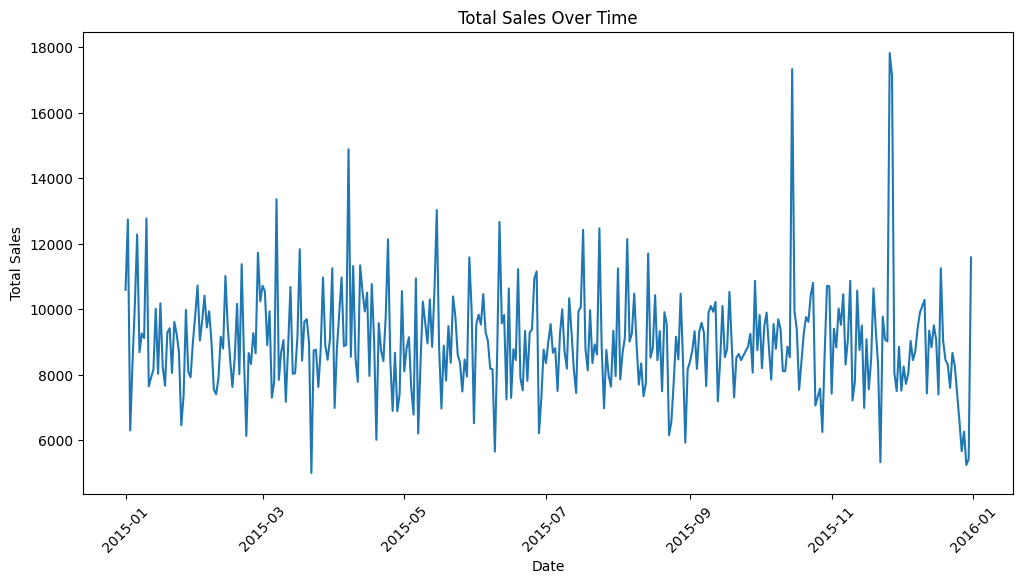

In [57]:
# Ploting sales over time
sales_over_time = merged_df.groupby('order_date')['total_price'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=sales_over_time, x='order_date', y='total_price')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.savefig("eda_results/sales_trend_over_time.png", dpi=300)
plt.show()

### ii) Top-Selling Pizzas

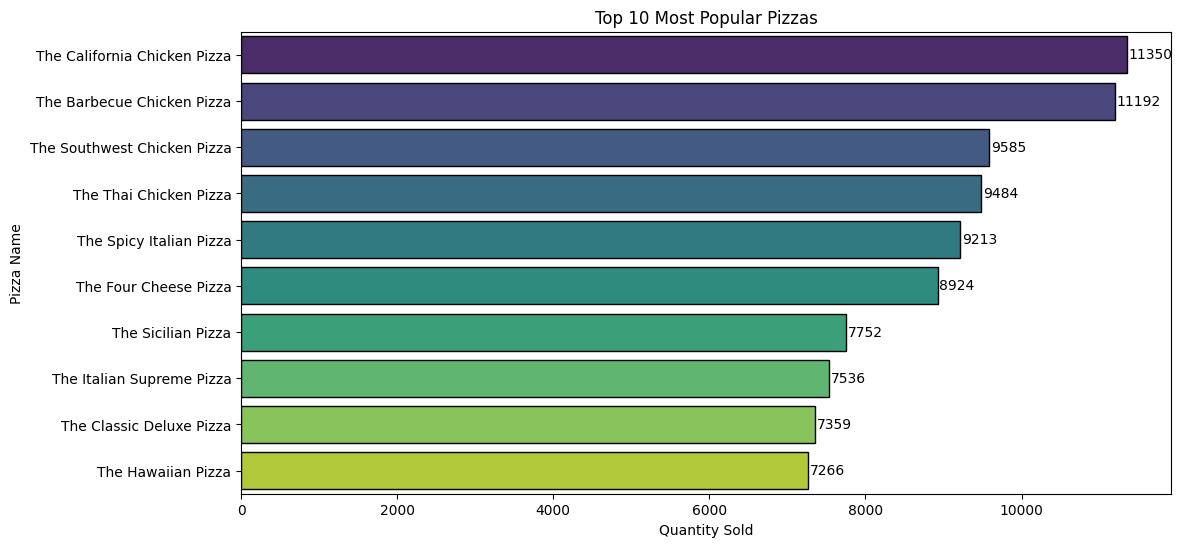

In [58]:
# Aggregate sales by pizza name
top_selled_pizzas = merged_df.groupby('pizza_name')['quantity'].sum().reset_index()

# Sorting by quantity sold
top_selled_pizzas = top_selled_pizzas.sort_values(by='quantity', ascending=False)

# Plotting top 10 most popular pizzas with values on the bars
plt.figure(figsize=(12, 6))
sns.barplot(data=top_selled_pizzas.head(10), x='quantity', y='pizza_name', palette='viridis', edgecolor="black")
plt.title('Top 10 Most Popular Pizzas')
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.savefig("eda_results/top_selled_pizzas.png", dpi=300)

# Annotate each bar with the quantity sold
for index, value in enumerate(top_selled_pizzas.head(10)['quantity']):
    plt.text(value + 20, index, str(value), va='center')
plt.show()

# Print the output counts
# print("Pizza Sales Quantities:", top_selled_pizzas)

### iii) Sales by Pizza Size

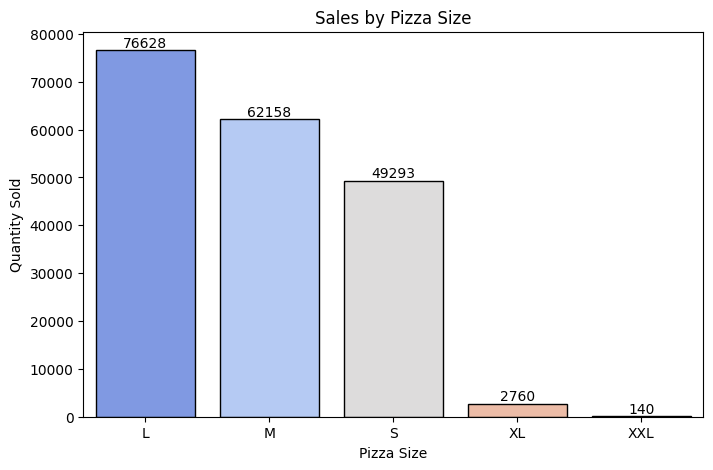

In [59]:
# Aggregate sales by pizza size
size_sales = merged_df.groupby('pizza_size')['quantity'].sum().reset_index()

# Ploting pizza size distribution
plt.figure(figsize=(8, 5))
sns.barplot(data=size_sales, x='pizza_size', y='quantity', palette='coolwarm', edgecolor="black")
plt.title('Sales by Pizza Size')
plt.xlabel('Pizza Size')
plt.ylabel('Quantity Sold')
plt.savefig("eda_results/sales_trend_by_size.png", dpi=300)

# Annotate each bar with the quantity sold
for index, value in enumerate(size_sales['quantity']):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom')
plt.show()

# Print the output counts
# print("Pizza Sales by size:\n", size_sales)

### iv) Sales by Pizza Category

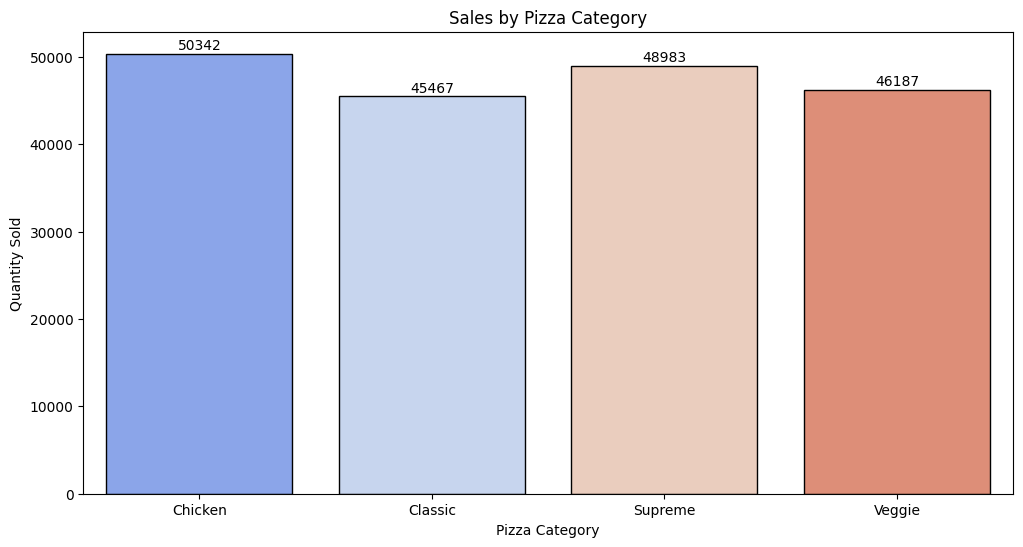

In [60]:
# Plotting pizza category distribution
category_sales = merged_df.groupby('pizza_category')['quantity'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=category_sales, x='pizza_category', y='quantity', palette='coolwarm', edgecolor='black')
plt.title('Sales by Pizza Category')
plt.xlabel('Pizza Category')
plt.ylabel('Quantity Sold')
plt.savefig("eda_results/sales_trend_by_category.png", dpi=300)

# Adding quantity labels on top of each bar
for index, row in category_sales.iterrows():
    plt.text(x=index, y=row['quantity']+ 500, s=row['quantity'], ha='center', color='black')
plt.show()

# Printing the output for verification
# print(category_sales)

### v) Seasonal Sales Trends and Patterns

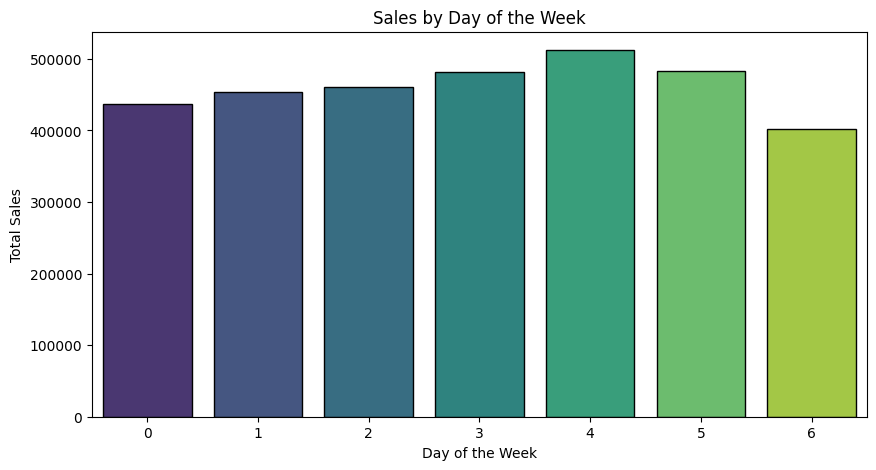

  day_of_week  total_price
0           0    437542.10
1           1    454238.80
2           2    460956.50
3           3    481875.80
4           4    512280.90
5           5    482354.20
6           6    401952.45


In [61]:
# Aggregate sales by day of the week
sales_by_day = merged_df.groupby('day_of_week')['total_price'].sum().reset_index()

# Order days of the week
# days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_order = [0, 1, 2, 3, 4, 5, 6]
sales_by_day['day_of_week'] = pd.Categorical(sales_by_day['day_of_week'], categories=days_order, ordered=True)

# Plot sales by day of the week
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_day, x='day_of_week', y='total_price', palette='viridis', edgecolor='black')
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.savefig("eda_results/sales_trend_per_week.png", dpi=300)
plt.show()

# Printing the output for verification
print(sales_by_day)

### vi) Sales by Month

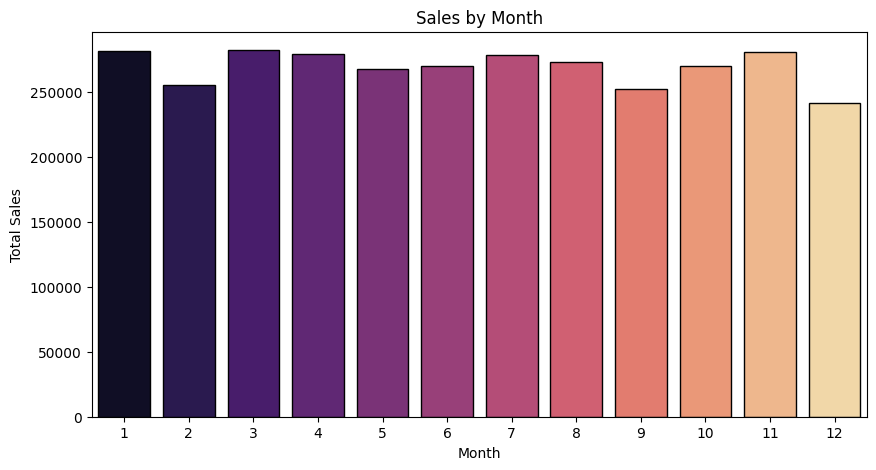

    month  total_price
0       1    281167.65
1       2    255292.90
2       3    282254.25
3       4    279196.35
4       5    267462.35
5       6    269720.65
6       7    278513.00
7       8    273275.80
8       9    251942.10
9      10    270230.55
10     11    280770.75
11     12    241374.40


In [62]:
# Aggregate sales by month
sales_by_month = merged_df.groupby('month')['total_price'].sum().reset_index()

# Plot sales by month
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_month, x='month', y='total_price', palette='magma', edgecolor='black')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.savefig("eda_results/sales_trend_per_month.png", dpi=300)
plt.show()

print(sales_by_month)

In [63]:
# Get column names with data types
numerical_columns = [col for col in merged_df.columns if merged_df[col].dtype in ['int64', 'float64']]
categorical_columns = [col for col in merged_df.columns if merged_df[col].dtype == 'object']

print("Numerical Columns:", numerical_columns)
print("Categorical Columns:", categorical_columns)

Numerical Columns: ['pizza_id', 'order_id', 'quantity', 'unit_price', 'total_price', 'Items_Qty_In_Grams', 'holiday', 'promotion']
Categorical Columns: ['pizza_name_id', 'order_time', 'pizza_size', 'pizza_category', 'pizza_ingredients', 'pizza_name']


In [64]:
# Skewness:
# Calculate statistical measures for all numerical columns
# numerical_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns

# Select specific columns for statistical analysis
selected_columns = ['quantity', 'unit_price', 'total_price']

# Calculate statistics and store in a dictionary
stats = {
    'mean': merged_df[numerical_columns].mean(),
    'median': merged_df[numerical_columns].median(),
    'mode': merged_df[numerical_columns].mode().iloc[0],  # .iloc[0] to handle multiple modes
    'std': merged_df[numerical_columns].std(),
    'var': merged_df[numerical_columns].var()
}

# Statistical summary
stats_df = pd.DataFrame(stats, index=selected_columns)
print("Statistical Summary of Numerical Columns:")
display(stats_df)

# Checking skewness of total_price to interpret distribution shape
if stats_df.loc['total_price', 'mean'] > stats_df.loc['total_price', 'median']:
    print("\nThe 'total_price' distribution is right-skewed (mean > median).")
elif stats_df.loc['total_price', 'mean'] < stats_df.loc['total_price', 'median']:
    print("\nThe 'total_price' distribution is left-skewed (mean < median).")
else:
    print("\nThe 'total_price' distribution is symmetric (mean ≈ median).")

Statistical Summary of Numerical Columns:


,mean,median,mode,std,var
quantity,1.019250,1.00,1.00,0.141575,0.020043
unit_price,16.914338,16.75,20.75,3.571451,12.755262
total_price,17.244843,16.75,20.75,4.419979,19.536214



The 'total_price' distribution is right-skewed (mean > median).


### vii) Outlier Detection in Sales Data

In [65]:
# Function to cap outliers based on IQR (INTERQUANTILE RANGE) method
def cap_outliers(df, column):
    # Calculate Q1, Q3, and IQR for the specified column
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define upper and lower limits for outliers
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Cap the outliers
    df[column] = df[column].clip(lower=lower_limit, upper=upper_limit)
    return df

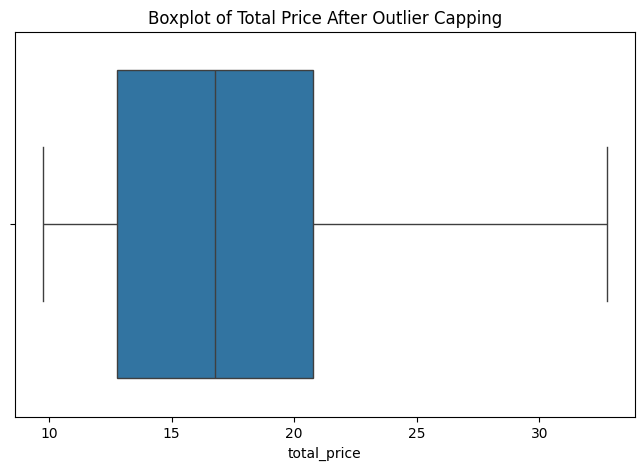

In [66]:
# Apply capping function to 'total_price' column
merged_df = cap_outliers(merged_df, 'total_price')

# Boxplot to verify outlier capping for 'total_price'
plt.figure(figsize=(8, 5))
sns.boxplot(data=merged_df, x='total_price')
plt.title('Boxplot of Total Price After Outlier Capping')
plt.show()

### viii) Correlation Analysis of Sales Metrics

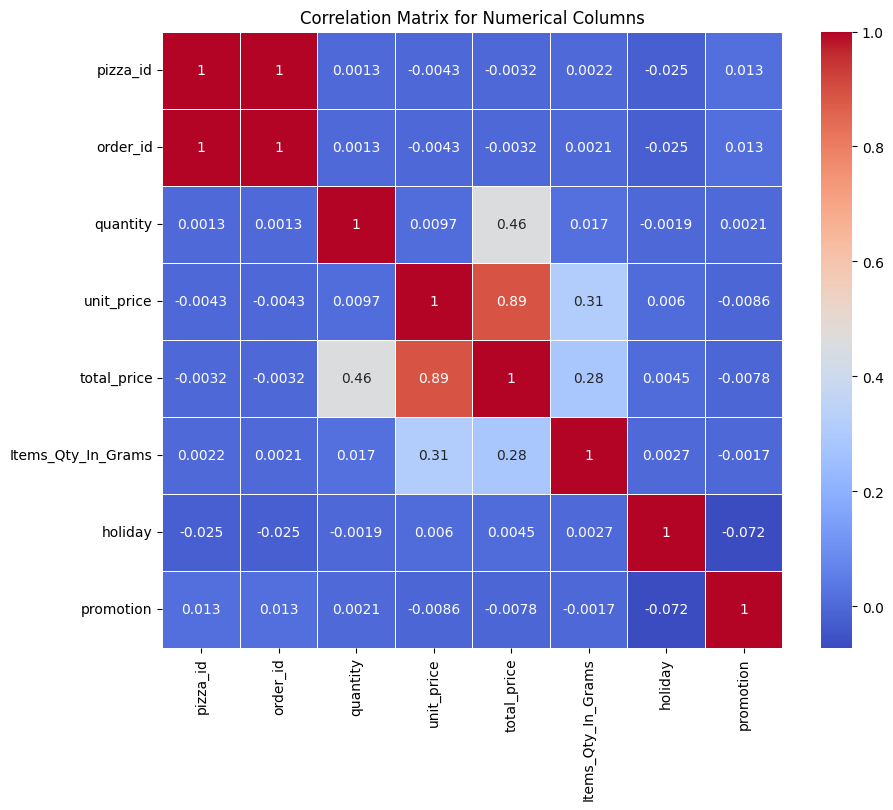

In [67]:
# Select only numerical columns
numerical_df = merged_df.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Display the correlation matrix
# print(correlation_matrix)

# Plot the correlation matrix as a heatmap for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix for Numerical Columns")
plt.savefig("eda_results/correlation.png", dpi=300)
plt.show()

### ix) Sales during holidays vs non-holidays

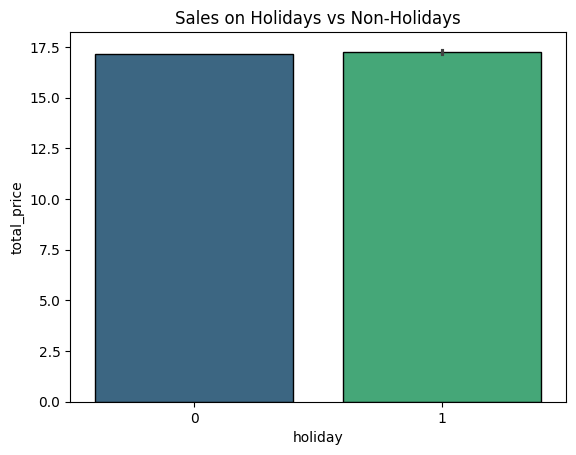

In [68]:
sns.barplot(x='holiday', y='total_price', data=merged_df, palette='viridis', edgecolor='black')
plt.title('Sales on Holidays vs Non-Holidays')
plt.savefig("eda_results/sales_on_holidays.png", dpi=300)
plt.show()

### x) Sales during promotions vs non-promotions

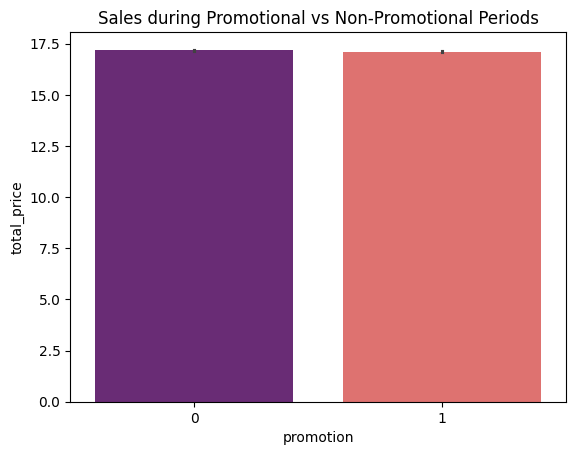

In [69]:
sns.barplot(x='promotion', y='total_price', data=merged_df, palette='magma')
plt.title('Sales during Promotional vs Non-Promotional Periods')
plt.savefig("eda_results/sales_trends_by_promotion.png", dpi=300)
plt.show()

ARIMA / SARIMA
ARIMA (AutoRegressive Integrated Moving Average) and SARIMA (Seasonal ARIMA) are great starting points if your data shows seasonal patterns and trends.

## 8. Model Selection

### ARIMA Model
* p (AutoRegressive term): The number of past observations (lags) used to predict the future value.
* d (Differencing term): The number of times the data is differenced to make it stationary.
* q (Moving Average term): The number of past forecast errors used to improve future predictions.

Best ARIMA Model MAPE: 20.77%, Best Parameters: (2, 0, 3)
Predictions:
order_date
2015-10-25    3519.852330
2015-11-01    3611.083931
2015-11-08    3724.759756
2015-11-15    3749.608048
2015-11-22    3640.778903
2015-11-29    3594.853706
2015-12-06    3694.754222
2015-12-13    3760.020473
2015-12-20    3672.793063
2015-12-27    3590.646548
2016-01-03    3661.934193
Freq: W-SUN, Name: predicted_mean, dtype: float64


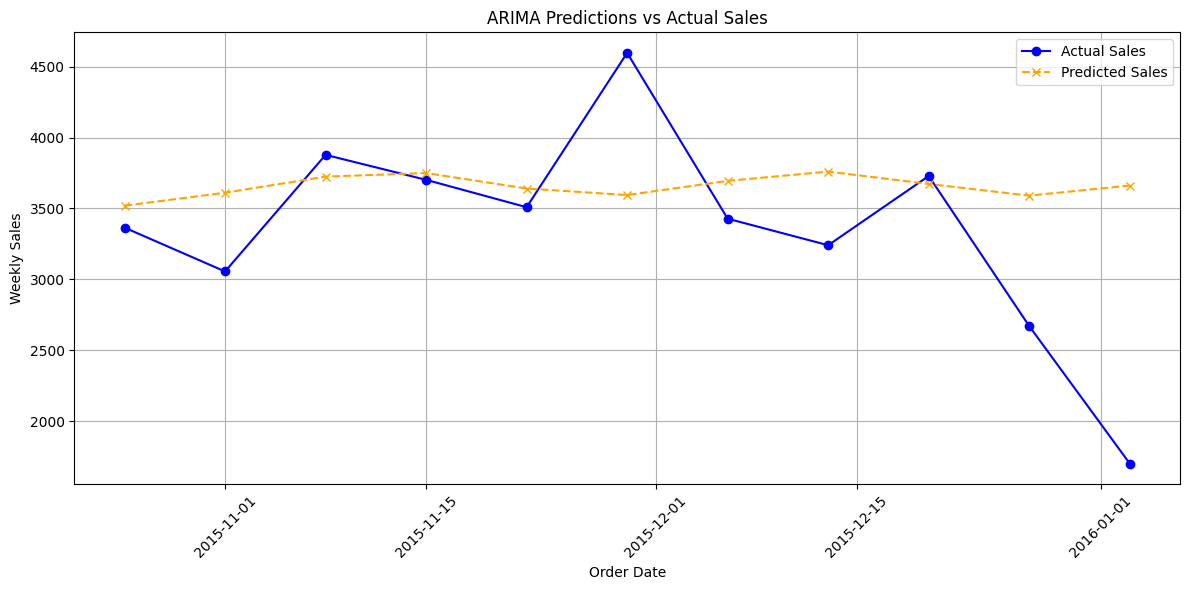

In [70]:
# Resample data for weekly intervals
def resample_weekly_sales(data, feature='order_date', target='quantity'):
    return data.groupby(feature)[target].sum().resample('W').sum()

# Split data into train and test sets (80% train, 20% test)
def train_test_split(data, train_ratio=0.8):
    train_size = int(len(data) * train_ratio)
    train, test = data[:train_size], data[train_size:]
    return train, test

# Calculate MAPE (Mean Absolute Percentage Error)
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# ARIMA Model Tuning with Best Parameters
def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            predictions = model.forecast(steps=len(test))
            arima_mape = mape(test, predictions)
            if arima_mape < best_score:
                best_score, best_params, best_predictions = arima_mape, (p, d, q), predictions
        except Exception as e:
            print(f"Error for ARIMA({p},{d},{q}): {e}")
            continue

    print(f"Best ARIMA Model MAPE: {best_score:.2f}%, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

# Function to plot actual vs predicted values
def plot_forecast(test, predictions, title='ARIMA Predictions vs Actual Sales'):
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
    plt.plot(predictions.index, predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
    plt.title(title)
    plt.xlabel('Order Date')
    plt.ylabel('Weekly Sales')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig("eda_results/ARIMA_model.png", dpi=300)
    plt.show()

# Main Function to execute ARIMA model tuning and sales forecasting
def arima_sales_forecasting(merged_df, feature='order_date', target='quantity', 
                            p_values=range(0, 4), d_values=range(0, 2), q_values=range(0, 4)):
    
    # Resample and prepare data
    weekly_sales = resample_weekly_sales(merged_df, feature, target)
    train, test = train_test_split(weekly_sales)

    # Tune ARIMA model and get best predictions
    predictions, mape_score, best_params = tune_arima_model(train, test, p_values, d_values, q_values)
    
    # Format predictions for display if tuning is successful
    if predictions is not None:
        predictions_series = pd.Series(predictions, index=test.index)
        print("Predictions:")
        print(predictions_series)
        plot_forecast(test, predictions_series)
    else:
        print("ARIMA model tuning failed to produce predictions.")

# display output of arima sales forecast
arima_sales_forecasting(merged_df)

### SARIMA (Seasonal ARIMA)
* P (Seasonal AutoRegressive term): The number of past seasonal values used for prediction.
* D (Seasonal Differencing term): The number of seasonal differencing applied to make data stationary.
* Q (Seasonal Moving Average term): The number of past seasonal forecast errors used for prediction.
* S (Seasonal Period): The length of the seasonal cycle (e.g., 12 for yearly seasonality in monthly data).

In [71]:
# # Function to check for stationarity
# def check_stationarity(data):
#     result = adfuller(data)
#     print(f'ADF Statistic: {result[0]}')
#     print(f'p-value: {result[1]}')
#     print('Critical Values:')
#     for key, value in result[4].items():
#         print(f'{key}:{value}')
#     if result[1] <= 0.05:
#         print("The series is stationary.")
#     else:
#         print("The series is non-stationary. Consider differencing the series.")

# # Check stationarity of the training set
# check_stationarity(train)

Best SARIMA Model MAPE: 18.93%, Best Parameters: (0, 0, 0, 1, 0, 0, 7)
Predictions:
order_date
2015-10-25    3601.007348
2015-11-01    3754.769370
2015-11-08    3688.304496
2015-11-15    2580.225926
2015-11-22    3740.881187
2015-11-29    3663.504170
2015-12-06    4062.293413
2015-12-13    3572.246259
2015-12-20    3724.780190
2015-12-27    3658.846168
2016-01-03    2559.617774
Freq: W-SUN, Name: predicted_mean, dtype: float64


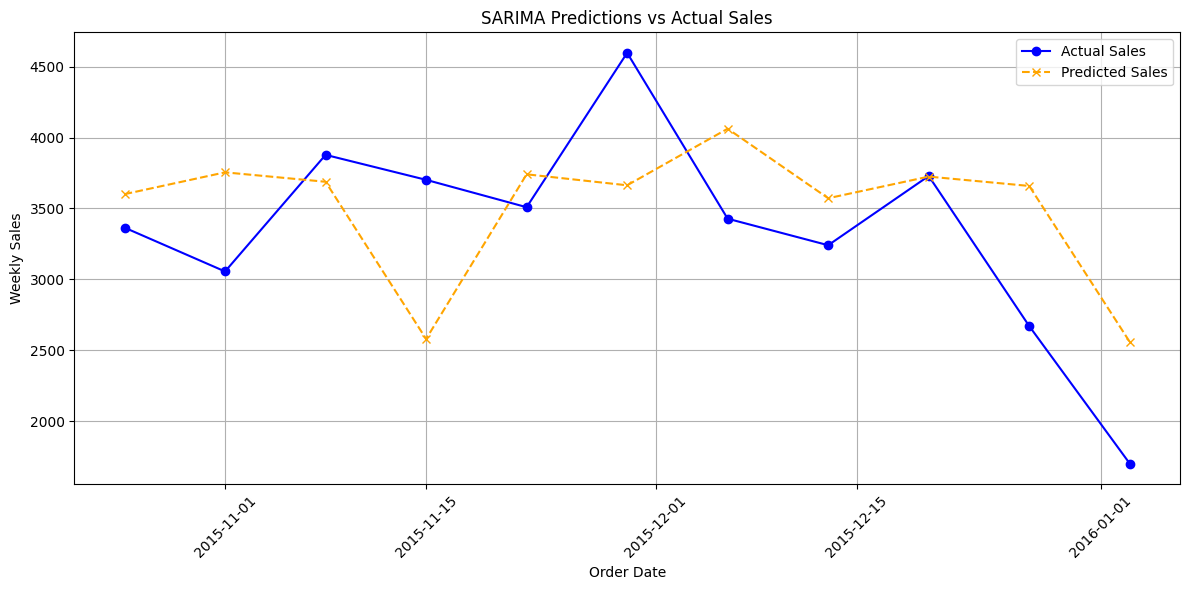

In [72]:
# Resample sales data to weekly intervals
def prepare_weekly_sales(data, target):
    weekly_sales = data.resample('W')[target].sum()
    return weekly_sales

# Split data into train and test sets
def train_test_split(data, train_ratio=0.8):
    train_size = int(len(data) * train_ratio)
    train, test = data[:train_size], data[train_size:]
    return train, test

# Calculate MAPE (Mean Absolute Percentage Error)
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Find the best SARIMA model
def best_sarima_model(train, test, p_values, d_values, q_values, P_values, D_values, Q_values, S):
    best_score, best_params, best_predictions = float("inf"), None, None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        for P, D, Q in itertools.product(P_values, D_values, Q_values):
            try:
                model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S)).fit(disp=False)
                predictions = model.forecast(steps=len(test))
                sarima_mape = mape(test, predictions)

                if sarima_mape < best_score:
                    best_score, best_params, best_predictions = sarima_mape, (p, d, q, P, D, Q, S), predictions
            except Exception as e:
                print(f"Error for SARIMA({p},{d},{q})x({P},{D},{Q},{S}): {e}")
                continue

    print(f"Best SARIMA Model MAPE: {best_score:.2f}%, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

# Function to plot actual vs. predicted sales
def plot_forecast(test, predictions, title='SARIMA Predictions vs Actual Sales'):
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
    plt.plot(predictions.index, predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
    plt.title(title)
    plt.xlabel('Order Date')
    plt.ylabel('Weekly Sales')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig("eda_results/SARIMA_model.png", dpi=300)
    plt.show()

# Main function to execute SARIMA model tuning and sales forecasting
def sarima_sales_forecasting(data, target='quantity', 
                             p_values=range(0, 3), d_values=range(0, 2), q_values=range(0, 3), 
                             P_values=range(0, 2), D_values=range(0, 2), Q_values=range(0, 2), S=7):
    
    # Prepare and split data
    weekly_sales = prepare_weekly_sales(data, target)
    train, test = train_test_split(weekly_sales)

    # Tune SARIMA model and get best predictions
    predictions, mape_score, best_params = best_sarima_model(train, test, p_values, d_values, q_values, P_values, D_values, Q_values, S)
    
    # Format predictions for display if tuning is successful
    if predictions is not None:
        predictions_series = pd.Series(predictions, index=test.index)
        print("Predictions:")
        print(predictions_series)
        plot_forecast(test, predictions_series)
    else:
        print("SARIMA model tuning failed to produce predictions.")

# display output of sarima sales forecast
sarima_sales_forecasting(pizza_sales)

### Prophet (Developed by Facebook)
#### Prophet is a popular model for handling time series data with seasonal and holiday effects.
The Facebook Prophet model is a tool developed by Facebook for forecasting time series data. It’s especially useful when you want to predict future values based on historical data, such as sales, temperatures, or website traffic.
* Growth: Defines the trend type (linear or logistic).
* Changepoints: Points where the trend changes.
* Seasonality: Models seasonal patterns (weekly, yearly, etc.).
* Holidays: Incorporates custom holidays or events affecting the forecast.
* Seasonality Mode: Can be additive or multiplicative.

14:03:23 - cmdstanpy - INFO - Chain [1] start processing
14:03:23 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model MAPE: 21.63%


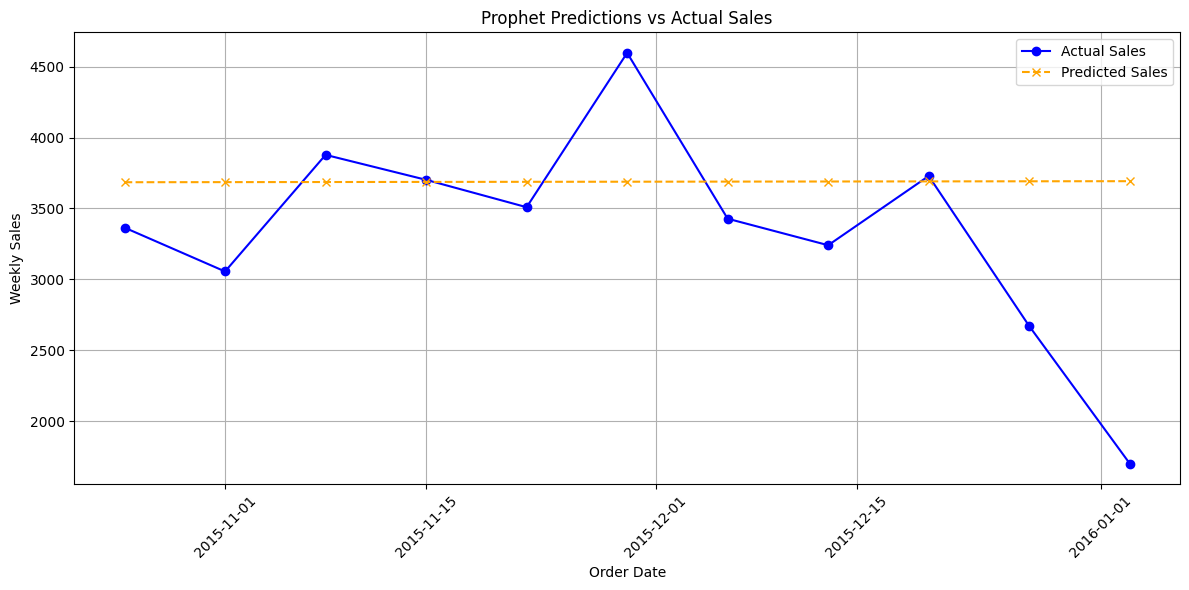

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Resample sales data to weekly intervals and prepare for Prophet
def prepare_weekly_sales(data, target):
    weekly_sales = data.resample('W')[target].sum().reset_index()
    weekly_sales.columns = ['ds', 'y']  # Rename for Prophet
    return weekly_sales

# Split data into train and test sets
def train_test_split(data, train_ratio=0.8):
    train_size = int(len(data) * train_ratio)
    train, test = data[:train_size], data[train_size:]
    return train, test

# Fit Prophet model and make predictions
def prophet_forecast(train, test):
    model = Prophet()
    model.fit(train)
    future = model.make_future_dataframe(periods=len(test), freq='W')
    forecast = model.predict(future)
    return forecast[['ds', 'yhat']].iloc[-len(test):].set_index('ds')

# Calculate MAPE (Mean Absolute Percentage Error)
def mape(actual, predicted):
    return mean_absolute_percentage_error(actual, predicted) * 100

# Function to plot actual vs. predicted sales
def plot_forecast(test, predictions, title='Prophet Predictions vs Actual Sales'):
    plt.figure(figsize=(12, 6))
    plt.plot(test['ds'], test['y'], label='Actual Sales', color='blue', marker='o')
    plt.plot(predictions.index, predictions['yhat'], label='Predicted Sales', color='orange', linestyle='--', marker='x')
    plt.title(title)
    plt.xlabel('Order Date')
    plt.ylabel('Weekly Sales')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig("eda_results/Prophet_model.png", dpi=300)
    plt.show()

# Main function to execute Prophet model forecasting
def prophet_sales_forecasting(data, target='quantity'):
    # Prepare and split data
    weekly_sales = prepare_weekly_sales(data, target)
    train, test = train_test_split(weekly_sales)

    # Fit Prophet model and get predictions
    predictions = prophet_forecast(train, test)
    mape_score = mape(test['y'], predictions['yhat'])
    
    print(f"Prophet Model MAPE: {mape_score:.2f}%")

    # Plot forecast
    plot_forecast(test, predictions)

# Display output of Prophet sales forecast
prophet_sales_forecasting(pizza_sales)

### Regression Model

Best Regression Model MAPE: 14.9212%
Predictions:
42    3653.324527
43    3738.797197
44    3714.476932
45    3690.156667
46    3665.836402
47    3641.516137
48    3726.988808
49    3702.668543
50    3678.348278
51    3654.028012
52    2421.985456
dtype: float64


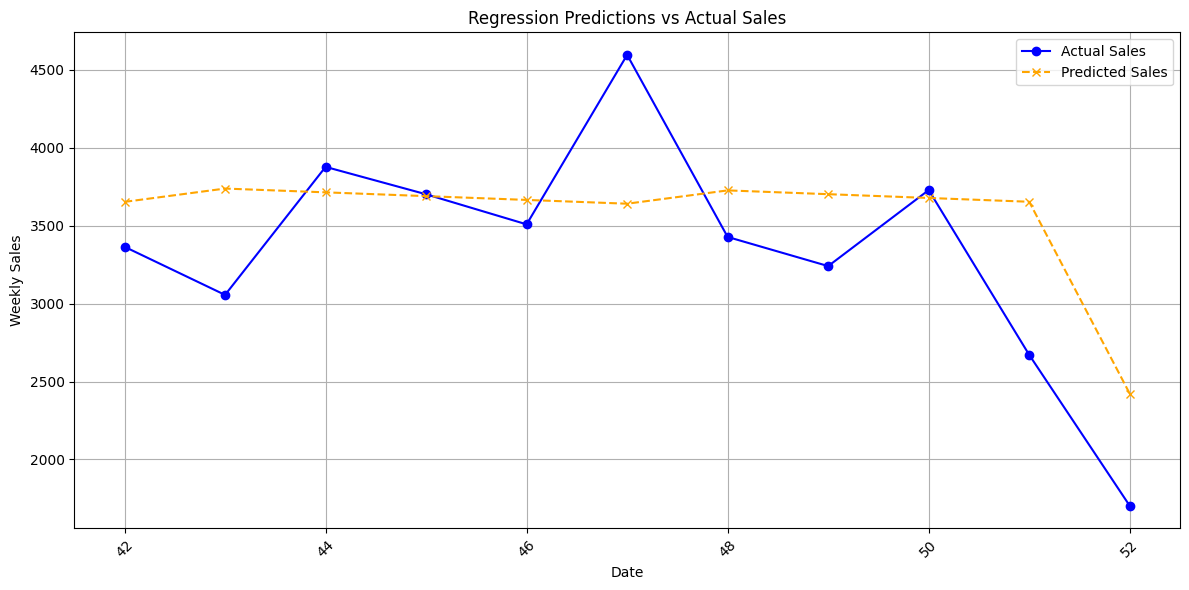

In [74]:
# Pizza sales by week
def prepare_weekly_sales(df):
    weekly_sales = df.resample('W')['quantity'].sum().reset_index()
    return weekly_sales

# Feature Engineering for Regression
def create_regression_features(df):
    df['week_of_year'] = df['order_date'].dt.isocalendar().week
    df['day_of_week'] = df['order_date'].dt.dayofweek
    df['month'] = df['order_date'].dt.month
    df['year'] = df['order_date'].dt.year
    return df

# Prepare weekly sales data
pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

# Ensure 'order_date' column exists after preparation
if 'order_date' not in pizza_sales_weekly.columns:
    print("Error: 'order_date' is not in the DataFrame columns after resampling.")
else:
    pizza_sales_weekly = create_regression_features(pizza_sales_weekly)

# Train-test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Prepare data for Regression
X_train = train[['week_of_year', 'day_of_week', 'month', 'year']]
y_train = train['quantity']
X_test = test[['week_of_year', 'day_of_week', 'month', 'year']]
y_test = test['quantity']

# MAPE function
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# Best Regression Model Training and Output
def best_regression_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    regression_mape = mape(y_test, predictions)
    
    print(f"Best Regression Model MAPE: {regression_mape:.4f}%")
    return predictions, regression_mape

# Train and evaluate the Regression model
regression_predictions, regression_mape_score = best_regression_model(X_train, y_train, X_test, y_test)

# Formatting the predictions for display
regression_predictions = pd.Series(regression_predictions, index=test.index)

print("Predictions:")
print(regression_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test, label='Actual Sales', color='blue', marker='o')
plt.plot(test.index, regression_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Regression Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### LSTM model

1/1 [==============================] - 0s 181ms/step
Best LSTM Model MAPE: 23.55%
Predictions:
order_date
2015-11-15    3496.791504
2015-11-22    3564.635010
2015-11-29    3700.448486
2015-12-06    3819.737793
2015-12-13    3793.994141
2015-12-20    3787.091553
2015-12-27    3524.109131
2016-01-03    3400.299072
dtype: float32


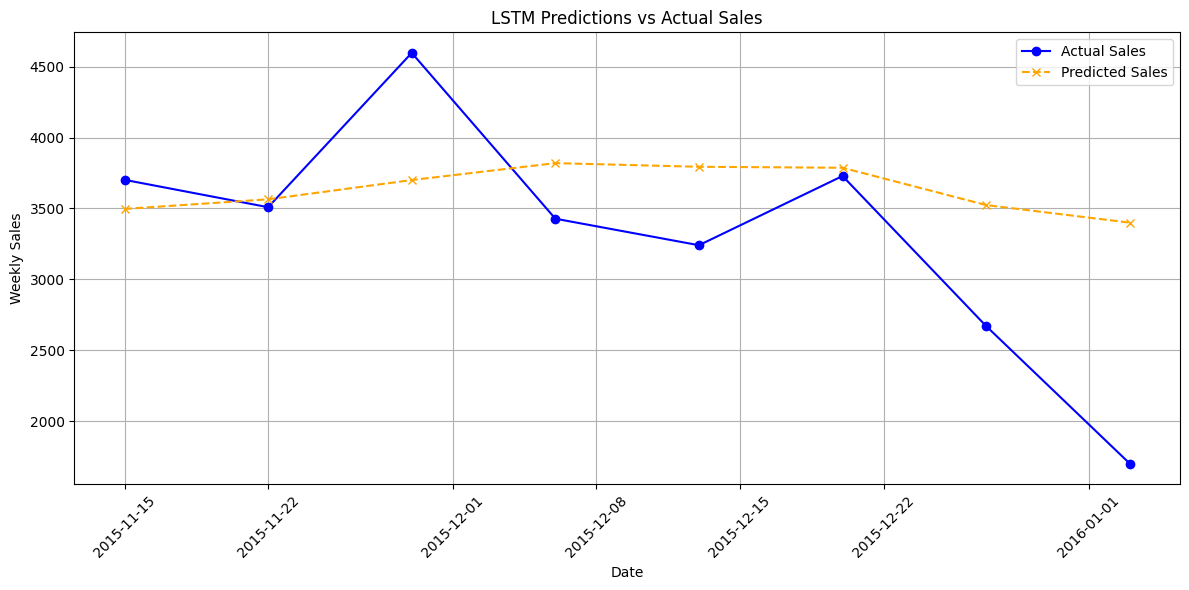

In [75]:
# Pizza sales by week
def prepare_weekly_sales(df):
    weekly_sales = df.resample('W')['quantity'].sum().reset_index()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Normalizeing the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['quantity']])
test_scaled = scaler.transform(test[['quantity']])

# Prepareing data for LSTM
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# Reshapeing X for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Training LSTM Model
def best_lstm_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    lstm_mape = mape(y_test_rescaled, predictions)
    
    print(f"Best LSTM Model MAPE: {lstm_mape:.2f}%")
    return predictions, lstm_mape, y_test_rescaled

# Train and evaluate the LSTM model
lstm_predictions, lstm_mape_score, y_test_rescaled = best_lstm_model(X_train, y_train, X_test, y_test)

# Formating the predictions for display
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test['order_date'][time_steps:])

print("Predictions:")
print(lstm_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'][time_steps:], y_test_rescaled, label='Actual Sales', color='blue', marker='o')
plt.plot(lstm_predictions.index, lstm_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('LSTM Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Forecasted sales for the week

In [76]:
# aggregate pizza_name_id with quantity
def prepare_weekly_sales_by_pizza(merged_df):
    weekly_sales = merged_df.groupby(['pizza_name_id']).resample('W')['quantity'].sum().reset_index()
    return weekly_sales

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(pizza_sales)

# Function to forecast sales for each pizza type using ARIMA
def forecast_sales_per_pizza_type_arima(pizza_type, train, periods=1):
    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()

    # Forecasting for the next week
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Forecasting next week's sales for each pizza type using ARIMA
def forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}

    # Total sales per pizza type
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza['order_date'].max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # Train-test split
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']

        # Forecast sales using ARIMA
        pizza_type, forecast = forecast_sales_per_pizza_type_arima(pizza_type, train, periods)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast
        else:
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Forecasting pizza sales for the next week using ARIMA
next_week_pizza_sales_forecasts_arima, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts_arima.items():
    forecast_value = int(forecast[0])
    next_week_pizza_sales_forecasts_arima[pizza_type] = forecast_value
    print(f'{pizza_type}: {forecast_value} pizzas')
    total_forecasted_quantity += forecast_value

print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-10 to 2016-01-16:
bbq_ckn_l: 90 pizzas
bbq_ckn_m: 91 pizzas
bbq_ckn_s: 27 pizzas
big_meat_s: 110 pizzas
brie_carre_s: 37 pizzas
calabrese_l: 19 pizzas
calabrese_m: 40 pizzas
calabrese_s: 7 pizzas
cali_ckn_l: 89 pizzas
cali_ckn_m: 95 pizzas
cali_ckn_s: 42 pizzas
ckn_alfredo_l: 16 pizzas
ckn_alfredo_m: 67 pizzas
ckn_alfredo_s: 8 pizzas
ckn_pesto_l: 30 pizzas
ckn_pesto_m: 18 pizzas
ckn_pesto_s: 20 pizzas
classic_dlx_l: 30 pizzas
classic_dlx_m: 67 pizzas
classic_dlx_s: 45 pizzas
five_cheese_l: 54 pizzas
four_cheese_l: 121 pizzas
four_cheese_m: 44 pizzas
green_garden_l: 10 pizzas
green_garden_m: 23 pizzas
green_garden_s: 47 pizzas
hawaiian_l: 48 pizzas
hawaiian_m: 27 pizzas
hawaiian_s: 56 pizzas
ital_cpcllo_l: 58 pizzas
ital_cpcllo_m: 27 pizzas
ital_cpcllo_s: 21 pizzas
ital_supr_l: 52 pizzas
ital_supr_m: 69 pizzas
ital_supr_s: 15 pizzas
ital_veggie_l: 20 pizzas
ital_veggie_m: 37 pizzas
ital_veggie_s: 17 pizzas
mediterraneo_l: 34 pizzas
mediterraneo_m: 2

In [77]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Aggregate pizza sales weekly by pizza type
def prepare_weekly_sales_by_pizza(merged_df):
    weekly_sales = merged_df.groupby(['pizza_name_id']).resample('W')['quantity'].sum().reset_index()
    return weekly_sales

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(pizza_sales)

# Forecast sales for each pizza type using SARIMA
def forecast_sales_per_pizza_type_sarima(pizza_type, train, periods=1, seasonal_period=52):
    # Setting SARIMA with seasonal order
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, seasonal_period))
    model_fit = model.fit(disp=False)

    # Forecasting for the next period(s)
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

# Forecasting next week's sales for each pizza type using SARIMA
def forecast_next_week_sales_by_pizza_type_sarima(pizza_sales_weekly_by_pizza, periods=1, seasonal_period=52):
    pizza_type_forecasts = {}

    # Total sales per pizza type
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza['order_date'].max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # Train-test split
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']

        # Forecast sales using SARIMA
        pizza_type, forecast = forecast_sales_per_pizza_type_sarima(pizza_type, train, periods, seasonal_period)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast
        else:
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Forecasting pizza sales for the next week using SARIMA
next_week_pizza_sales_forecasts_sarima, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_sarima(pizza_sales_weekly_by_pizza, periods=1)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts_sarima.items():
    forecast_value = int(forecast[0])
    next_week_pizza_sales_forecasts_sarima[pizza_type] = forecast_value
    print(f'{pizza_type}: {forecast_value} pizzas')
    total_forecasted_quantity += forecast_value

print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-10 to 2016-01-16:
bbq_ckn_l: 85 pizzas
bbq_ckn_m: 140 pizzas
bbq_ckn_s: 24 pizzas
big_meat_s: 111 pizzas
brie_carre_s: 28 pizzas
calabrese_l: 32 pizzas
calabrese_m: 48 pizzas
calabrese_s: 8 pizzas
cali_ckn_l: 69 pizzas
cali_ckn_m: 55 pizzas
cali_ckn_s: 56 pizzas
ckn_alfredo_l: 10 pizzas
ckn_alfredo_m: 90 pizzas
ckn_alfredo_s: 0 pizzas
ckn_pesto_l: 36 pizzas
ckn_pesto_m: 28 pizzas
ckn_pesto_s: 32 pizzas
classic_dlx_l: 36 pizzas
classic_dlx_m: 66 pizzas
classic_dlx_s: 45 pizzas
five_cheese_l: 54 pizzas
four_cheese_l: 175 pizzas
four_cheese_m: 48 pizzas
green_garden_l: 5 pizzas
green_garden_m: 16 pizzas
green_garden_s: 48 pizzas
hawaiian_l: 63 pizzas
hawaiian_m: 27 pizzas
hawaiian_s: 75 pizzas
ital_cpcllo_l: 52 pizzas
ital_cpcllo_m: 36 pizzas
ital_cpcllo_s: 28 pizzas
ital_supr_l: 32 pizzas
ital_supr_m: 64 pizzas
ital_supr_s: 16 pizzas
ital_veggie_l: 36 pizzas
ital_veggie_m: 40 pizzas
ital_veggie_s: 21 pizzas
mediterraneo_l: 30 pizzas
mediterraneo_m: 3

### Prophet Evaluation

In [78]:
# Function to forecast sales for each pizza type using Prophet
def forecast_sales_per_pizza_type_prophet(pizza_type, train, periods=1):
    # Prepare the data for Prophet
    train_prophet = train.reset_index().rename(columns={'order_date': 'ds', 'quantity': 'y'})
    
    # Fit the Prophet model
    model = Prophet()
    model.fit(train_prophet)

    # Create a DataFrame to hold the future dates
    future = model.make_future_dataframe(periods=periods)
    
    # Forecasting
    forecast = model.predict(future)
    return pizza_type, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)

# Forecasting next week's sales for each pizza type using Prophet
def forecast_next_week_sales_by_pizza_type_prophet(pizza_sales_weekly_by_pizza, periods=7):
    pizza_type_forecasts = {}

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza['order_date'].max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # Train-test split
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]

        # Forecast sales using Prophet
        pizza_type, forecast = forecast_sales_per_pizza_type_prophet(pizza_type, train, periods)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast['yhat'].sum()
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, next_week_start, next_week_end

# Forecasting pizza sales for the next week using Prophet
sales_forecasts_prophet, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_prophet(pizza_sales_weekly_by_pizza)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = sum(sales_forecasts_prophet.values())

for pizza_type, forecast in sales_forecasts_prophet.items():
    print(f'{pizza_type}: {int(forecast)} pizzas')

print(f"Total quantity of units sold in the predicted week: {int(total_forecasted_quantity)} pizzas")

14:04:07 - cmdstanpy - INFO - Chain [1] start processing
14:04:07 - cmdstanpy - INFO - Chain [1] done processing
14:04:07 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: bbq_ckn_l


14:04:08 - cmdstanpy - INFO - Chain [1] done processing
14:04:08 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: bbq_ckn_m


14:04:08 - cmdstanpy - INFO - Chain [1] done processing
14:04:08 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: bbq_ckn_s


14:04:08 - cmdstanpy - INFO - Chain [1] done processing
14:04:08 - cmdstanpy - INFO - Chain [1] start processing
14:04:08 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: big_meat_s


14:04:09 - cmdstanpy - INFO - Chain [1] start processing
14:04:09 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: brie_carre_s


14:04:09 - cmdstanpy - INFO - Chain [1] start processing
14:04:09 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: calabrese_l


14:04:09 - cmdstanpy - INFO - Chain [1] start processing
14:04:09 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: calabrese_m
Forecast failed for pizza type: calabrese_s


14:04:09 - cmdstanpy - INFO - Chain [1] start processing
14:04:09 - cmdstanpy - INFO - Chain [1] done processing
14:04:09 - cmdstanpy - INFO - Chain [1] start processing
14:04:10 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: cali_ckn_l


14:04:10 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: cali_ckn_m


14:04:10 - cmdstanpy - INFO - Chain [1] done processing
14:04:10 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: cali_ckn_s


14:04:10 - cmdstanpy - INFO - Chain [1] done processing
14:04:10 - cmdstanpy - INFO - Chain [1] start processing
14:04:10 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: ckn_alfredo_l


14:04:10 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: ckn_alfredo_m


14:04:11 - cmdstanpy - INFO - Chain [1] done processing
14:04:11 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: ckn_alfredo_s


14:04:11 - cmdstanpy - INFO - Chain [1] done processing
14:04:11 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: ckn_pesto_l


14:04:11 - cmdstanpy - INFO - Chain [1] done processing
14:04:11 - cmdstanpy - INFO - Chain [1] start processing
14:04:11 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: ckn_pesto_m


14:04:11 - cmdstanpy - INFO - Chain [1] start processing
14:04:11 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: ckn_pesto_s


14:04:12 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: classic_dlx_l


14:04:12 - cmdstanpy - INFO - Chain [1] done processing
14:04:12 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: classic_dlx_m


14:04:12 - cmdstanpy - INFO - Chain [1] done processing
14:04:12 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: classic_dlx_s


14:04:12 - cmdstanpy - INFO - Chain [1] done processing
14:04:12 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: five_cheese_l


14:04:12 - cmdstanpy - INFO - Chain [1] done processing
14:04:13 - cmdstanpy - INFO - Chain [1] start processing
14:04:13 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: four_cheese_l


14:04:13 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: four_cheese_m


14:04:13 - cmdstanpy - INFO - Chain [1] done processing
14:04:13 - cmdstanpy - INFO - Chain [1] start processing
14:04:13 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: green_garden_l


14:04:13 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: green_garden_m


14:04:13 - cmdstanpy - INFO - Chain [1] done processing
14:04:14 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: green_garden_s


14:04:14 - cmdstanpy - INFO - Chain [1] done processing
14:04:14 - cmdstanpy - INFO - Chain [1] start processing
14:04:14 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: hawaiian_l


14:04:14 - cmdstanpy - INFO - Chain [1] start processing
14:04:14 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: hawaiian_m


14:04:14 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: hawaiian_s


14:04:14 - cmdstanpy - INFO - Chain [1] done processing
14:04:15 - cmdstanpy - INFO - Chain [1] start processing
14:04:15 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: ital_cpcllo_l


14:04:15 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: ital_cpcllo_m


14:04:15 - cmdstanpy - INFO - Chain [1] done processing
14:04:15 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: ital_cpcllo_s


14:04:15 - cmdstanpy - INFO - Chain [1] done processing
14:04:15 - cmdstanpy - INFO - Chain [1] start processing
14:04:15 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: ital_supr_l


14:04:16 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: ital_supr_m


14:04:16 - cmdstanpy - INFO - Chain [1] done processing
14:04:16 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: ital_supr_s


14:04:16 - cmdstanpy - INFO - Chain [1] done processing
14:04:16 - cmdstanpy - INFO - Chain [1] start processing
14:04:16 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: ital_veggie_l


14:04:16 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: ital_veggie_m


14:04:17 - cmdstanpy - INFO - Chain [1] done processing
14:04:17 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: ital_veggie_s


14:04:17 - cmdstanpy - INFO - Chain [1] done processing
14:04:17 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: mediterraneo_l


14:04:17 - cmdstanpy - INFO - Chain [1] done processing
14:04:17 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: mediterraneo_m


14:04:17 - cmdstanpy - INFO - Chain [1] done processing
14:04:18 - cmdstanpy - INFO - Chain [1] start processing
14:04:18 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: mediterraneo_s


14:04:18 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: mexicana_l


14:04:18 - cmdstanpy - INFO - Chain [1] done processing
14:04:18 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: mexicana_m


14:04:18 - cmdstanpy - INFO - Chain [1] done processing
14:04:18 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: mexicana_s


14:04:18 - cmdstanpy - INFO - Chain [1] done processing
14:04:19 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: napolitana_l


14:04:19 - cmdstanpy - INFO - Chain [1] done processing
14:04:19 - cmdstanpy - INFO - Chain [1] start processing
14:04:19 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: napolitana_m


14:04:19 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: napolitana_s


14:04:19 - cmdstanpy - INFO - Chain [1] done processing
14:04:19 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: pep_msh_pep_l


14:04:19 - cmdstanpy - INFO - Chain [1] done processing
14:04:20 - cmdstanpy - INFO - Chain [1] start processing
14:04:20 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: pep_msh_pep_m


14:04:20 - cmdstanpy - INFO - Chain [1] start processing
14:04:20 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: pep_msh_pep_s


14:04:20 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: pepperoni_l


14:04:20 - cmdstanpy - INFO - Chain [1] done processing
14:04:20 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: pepperoni_m


14:04:20 - cmdstanpy - INFO - Chain [1] done processing
14:04:21 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: pepperoni_s


14:04:21 - cmdstanpy - INFO - Chain [1] done processing
14:04:21 - cmdstanpy - INFO - Chain [1] start processing
14:04:21 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: peppr_salami_l


14:04:21 - cmdstanpy - INFO - Chain [1] start processing
14:04:21 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: peppr_salami_m


14:04:21 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: peppr_salami_s


14:04:21 - cmdstanpy - INFO - Chain [1] done processing
14:04:22 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: prsc_argla_l


14:04:22 - cmdstanpy - INFO - Chain [1] done processing
14:04:22 - cmdstanpy - INFO - Chain [1] start processing
14:04:22 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: prsc_argla_m


14:04:22 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: prsc_argla_s


14:04:22 - cmdstanpy - INFO - Chain [1] done processing
14:04:22 - cmdstanpy - INFO - Chain [1] start processing
14:04:22 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: sicilian_l


14:04:23 - cmdstanpy - INFO - Chain [1] start processing
14:04:23 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: sicilian_m


14:04:23 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: sicilian_s


14:04:23 - cmdstanpy - INFO - Chain [1] done processing
14:04:23 - cmdstanpy - INFO - Chain [1] start processing
14:04:23 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: soppressata_l


14:04:23 - cmdstanpy - INFO - Chain [1] start processing
14:04:23 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: soppressata_m


14:04:23 - cmdstanpy - INFO - Chain [1] start processing
14:04:24 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: soppressata_s


14:04:24 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: southw_ckn_l


14:04:24 - cmdstanpy - INFO - Chain [1] done processing
14:04:24 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: southw_ckn_m


14:04:24 - cmdstanpy - INFO - Chain [1] done processing
14:04:24 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: southw_ckn_s


14:04:24 - cmdstanpy - INFO - Chain [1] done processing
14:04:24 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: spicy_ital_l


14:04:25 - cmdstanpy - INFO - Chain [1] done processing
14:04:25 - cmdstanpy - INFO - Chain [1] start processing
14:04:25 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: spicy_ital_m


14:04:25 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: spicy_ital_s


14:04:25 - cmdstanpy - INFO - Chain [1] done processing
14:04:25 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: spin_pesto_l


14:04:25 - cmdstanpy - INFO - Chain [1] done processing
14:04:25 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: spin_pesto_m


14:04:26 - cmdstanpy - INFO - Chain [1] done processing
14:04:26 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: spin_pesto_s


14:04:26 - cmdstanpy - INFO - Chain [1] done processing
14:04:26 - cmdstanpy - INFO - Chain [1] start processing
14:04:26 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: spinach_fet_l


14:04:26 - cmdstanpy - INFO - Chain [1] start processing
14:04:26 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: spinach_fet_m


14:04:26 - cmdstanpy - INFO - Chain [1] start processing
14:04:26 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: spinach_fet_s


14:04:27 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: spinach_supr_l


14:04:27 - cmdstanpy - INFO - Chain [1] done processing
14:04:27 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: spinach_supr_m


14:04:27 - cmdstanpy - INFO - Chain [1] done processing
14:04:27 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: spinach_supr_s


14:04:27 - cmdstanpy - INFO - Chain [1] done processing
14:04:27 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: thai_ckn_l


14:04:28 - cmdstanpy - INFO - Chain [1] done processing
14:04:28 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: thai_ckn_m


14:04:28 - cmdstanpy - INFO - Chain [1] done processing
14:04:28 - cmdstanpy - INFO - Chain [1] start processing
14:04:28 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: thai_ckn_s


14:04:28 - cmdstanpy - INFO - Chain [1] start processing
14:04:28 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: the_greek_l


14:04:28 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: the_greek_m


14:04:29 - cmdstanpy - INFO - Chain [1] done processing
14:04:29 - cmdstanpy - INFO - Chain [1] start processing


Forecast failed for pizza type: the_greek_s


14:04:29 - cmdstanpy - INFO - Chain [1] done processing
14:04:29 - cmdstanpy - INFO - Chain [1] start processing
14:04:29 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: the_greek_xl
Forecast failed for pizza type: the_greek_xxl


14:04:29 - cmdstanpy - INFO - Chain [1] start processing
14:04:29 - cmdstanpy - INFO - Chain [1] done processing
14:04:29 - cmdstanpy - INFO - Chain [1] start processing
14:04:30 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: veggie_veg_l


14:04:30 - cmdstanpy - INFO - Chain [1] start processing
14:04:30 - cmdstanpy - INFO - Chain [1] done processing


Forecast failed for pizza type: veggie_veg_m
Forecast failed for pizza type: veggie_veg_s
Forecasted sales for the week 2016-01-10 to 2016-01-16:
bbq_ckn_l: 587 pizzas
bbq_ckn_m: 671 pizzas
bbq_ckn_s: 190 pizzas
big_meat_s: 807 pizzas
brie_carre_s: 269 pizzas
calabrese_l: 147 pizzas
calabrese_m: 280 pizzas
calabrese_s: 50 pizzas
cali_ckn_l: 651 pizzas
cali_ckn_m: 596 pizzas
cali_ckn_s: 267 pizzas
ckn_alfredo_l: 131 pizzas
ckn_alfredo_m: 491 pizzas
ckn_alfredo_s: 57 pizzas
ckn_pesto_l: 209 pizzas
ckn_pesto_m: 144 pizzas
ckn_pesto_s: 162 pizzas
classic_dlx_l: 184 pizzas
classic_dlx_m: 482 pizzas
classic_dlx_s: 347 pizzas
five_cheese_l: 363 pizzas
four_cheese_l: 891 pizzas
four_cheese_m: 312 pizzas
green_garden_l: 69 pizzas
green_garden_m: 168 pizzas
green_garden_s: 322 pizzas
hawaiian_l: 371 pizzas
hawaiian_m: 201 pizzas
hawaiian_s: 381 pizzas
ital_cpcllo_l: 419 pizzas
ital_cpcllo_m: 199 pizzas
ital_cpcllo_s: 121 pizzas
ital_supr_l: 384 pizzas
ital_supr_m: 480 pizzas
ital_supr_s: 104 piz

In [79]:
pizza_sales_weekly_by_pizza

,pizza_name_id,order_date,quantity
0,bbq_ckn_l,2015-01-04,60
1,bbq_ckn_l,2015-01-11,125
2,bbq_ckn_l,2015-01-18,120
3,bbq_ckn_l,2015-01-25,75
4,bbq_ckn_l,2015-02-01,135
...,...,...,...
4806,veggie_veg_s,2015-12-06,40
4807,veggie_veg_s,2015-12-13,28
4808,veggie_veg_s,2015-12-20,24
4809,veggie_veg_s,2015-12-27,24


## 9. Model Evaluation
**AIC (Akaike Information Criterion)** is a statistical measure used for model comparison that quantifies the trade-off between model goodness of fit and complexity, with lower AIC values indicating better model performance.

In [80]:
import pandas as pd

# Model results as a dictionary
model_performance = {
    'Model': ['ARIMA', 'SARIMA', 'Prophet', 'Regression', 'LSTM'],
    'MAPE': [0.2077, 0.1893, 0.2163, 0.1492, 0.2352]
}

# Createing a DataFrame
df_performance = pd.DataFrame(model_performance)

# Highlight best and worst models
df_performance['Rank'] = df_performance['MAPE'].rank()
df_performance = df_performance.sort_values('MAPE', ascending=True)
df_performance['Best/Worst'] = df_performance['MAPE'].apply(lambda x: 'Best' if x == df_performance['MAPE'].min() else 'Worst' if x == df_performance['MAPE'].max() else '')

# Display table
df_performance

,Model,MAPE,Rank,Best/Worst
3,Regression,0.1492,1.0,Best
1,SARIMA,0.1893,2.0,
0,ARIMA,0.2077,3.0,
2,Prophet,0.2163,4.0,
4,LSTM,0.2352,5.0,Worst


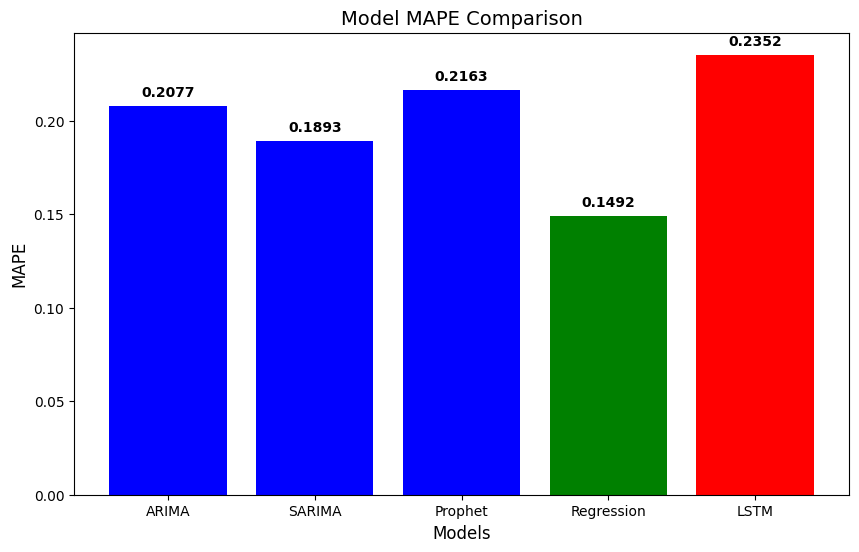

In [81]:
import matplotlib.pyplot as plt

# Data for plotting
models = ['ARIMA', 'SARIMA', 'Prophet', 'Regression', 'LSTM']
mapes = [0.2077, 0.1893, 0.2163, 0.1492, 0.2352]

plt.figure(figsize=(10,6))
plt.bar(models, mapes, color=['blue', 'blue', 'blue', 'green', 'red'])

# Highlighting the best and worst models
plt.title('Model MAPE Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAPE', fontsize=12)

for i, v in enumerate(mapes):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

plt.show()